# Setup Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from UtilityMethods import utils
import sys
#import gym
import pickle
import time
import pulp as p
import math
from copy import copy
import pprint as pp
import itertools
from tqdm import tqdm

## Global variables

In [4]:
# Global variables

IS_VISIT_DEPENDENT = False # whether the above empirical estimates are visit-dependent or not
DATA = '../../../../Codes/Accord/data/ACCORD_BPClass_v2.csv'

EPISODE_LENGTH = 40 # average number of visits per patient
CONSTRAINT = 10 * EPISODE_LENGTH # 10*40 = 400 
C_b = 0  # change this if you want different baseline policy.

NUMBER_EPISODES = 1e4
NUMBER_SIMULATIONS = 1

delta = 0.01 # bound

EPS = 0.01 # not used
M = 0 # not used

## State space and action space

In [2]:
# state space, actions available in each state are always the same
"""
state_features = ['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete','BMI_discrete'] 
fea1 = ['0', '1', '2', '3'] # possible values for sbp_discrete
fea2 = ['0', '1', '2', '3', '4', '5', '6', '7']
fea3 = ['0', '1', '2', '3']
fea4 = ['0', '1', '2', '3']
fea5 = ['0', '1', '2', '3']
"""

state_features = ['sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete'] 
fea1 = ['0', '1', '2'] # possible values for sbp_discrete, merge 3 with 2
fea2 = ['0', '1', '2', '3'] # merge every 2 adjacent levels into 1 level
fea3 = ['0', '1', '2'] # possible values for TC_discrete, merge 3 with 2
fea4 = ['0', '1', '2'] # merge hdl_discrete 3 with 2

combinations = itertools.product(fea1, fea2, fea3, fea4)
states = [''.join(i) for i in combinations]
print('len(states) =', len(states))
print(states[:5])

N_STATES = len(states) # number of states = 2048
state_code_to_index = {code: i for i, code in enumerate(states)}
# print the first 5 state_code_to_index
for i in range(5):
    print(states[i], state_code_to_index[states[i]])
print()

# action space, 000000000 means bpclass_none, 111111111 means all bpmed class are precribed
"""
action_features = ['Diur', 'ACE', 'Beta-blocker', 'CCB', 'ARB', 
                   'Alpha-Beta-blocker', 'Alpha-blocker', 'Sympath', 'Vasod'] # we donot include 'bpclass_none' as a action, because 000000000 means bpclass_none
"""

action_features = ['Diur', 'ACE', 'Beta-blocker', 'CCB', 'ARB'] 

combinations = list(itertools.product('01', repeat=len(action_features)))
actions = [''.join(i) for i in combinations]
print('len(actions) =', len(actions))
N_ACTIONS = len(actions) # number of actions = 512
action_code_to_index = {code: i for i, code in enumerate(actions)}
# print the first 5 action_code_to_index
for i in range(5):
    print(actions[i], action_code_to_index[actions[i]])


# build the action space for each state, assign the same action space to all states
actions_per_state = {}
for s in range(N_STATES):
    actions_per_state[s] = [i for i in range(N_ACTIONS)]
print('action_space for state 0:', actions_per_state[0])

len(states) = 108
['0000', '0001', '0002', '0010', '0011']
0000 0
0001 1
0002 2
0010 3
0011 4

len(actions) = 32
00000 0
00001 1
00010 2
00011 3
00100 4
action_space for state 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


## Calculate empirical estimates of P, R, C

In [5]:
df = pd.read_csv(DATA)

In [6]:
hba1c_discrete_code_dict = {'0': '0', '1': '0', 
                            '2': '1', '3': '1', 
                            '4': '2', '5': '2', 
                            '6': '3', '7': '3'}

# add the state and action code columns
action_code = []
state_code = []
for i in range(len(df)):
    row = df.iloc[i]
    s_code = ''
    a_code = ''
    for state_fea in state_features:
        code = str(row[state_fea])

        # merge 3 with 2 for sbp_discrete and TC_discrete
        if state_fea == 'sbp_discrete' and code == '3':
            code = '2'
        if state_fea == 'TC_discrete' and code == '3':
            code = '2'
        if state_fea == 'hdl_discrete' and code == '3':
            code = '2'

        # merge every 2 adjacent levels into 1 level for hba1c_discrete
        if state_fea == 'hba1c_discrete':
            code = hba1c_discrete_code_dict[code]
        
        s_code += code
    
    for action_fea in action_features:
        a_code += str(row[action_fea])
    
    action_code.append(a_code)
    state_code.append(s_code)

df['action_code'] = action_code
df['state_code'] = state_code
print('Finished adding action_code and state_code columns')

Finished adding action_code and state_code columns


In [7]:
#------------- calculate the empirical estimate of P, R, C
        
count_s_a = {} # count the number of times state s and action a appear in the dataset, sparse format
count_s_a_d = {} # count the number of times state s, action a, and next state s' appear in the dataset
sum_r_s_a = {} # sum of the reward of state s and action a
sum_c_s_a = {} # sum of the cost of state s and action a
visit_number = [] # number of visits for each patient

# loop through each patient in the dataset
for i in tqdm(range(100001, 110252)):
    df_patient = df[df['MaskID'] == i]

    if len(df_patient) > 0:
        visit_number.append(len(df_patient))

    # loop through each visit of the patient
    for j in range(len(df_patient)-1): # loop before last visit
        row = df_patient.iloc[j]
        s_code = row['state_code']
        a_code = row['action_code']
        ns_code = df_patient.iloc[j+1]['state_code']

        # convert from code to index
        s = state_code_to_index[s_code]
        a = action_code_to_index[a_code]
        s_ = state_code_to_index[ns_code]

        r = df_patient.iloc[j]['CVDRisk_feedback']
        c = df_patient.iloc[j]['sbp_feedback']

        if (s, a) not in count_s_a:
            count_s_a[(s, a)] = 1
            sum_r_s_a[(s, a)] = r 
            sum_c_s_a[(s, a)] = c
        else:
            count_s_a[(s, a)] += 1
            sum_r_s_a[(s, a)] += r
            sum_c_s_a[(s, a)] += c

        if (s, a, s_) not in count_s_a_d:
            count_s_a_d[(s, a, s_)] = 1
        else:
            count_s_a_d[(s, a, s_)] += 1

print('len(visit_number) =', len(visit_number))
print('averge visit_number =', sum(visit_number)/len(visit_number))

print('len(count_s_a) =', len(count_s_a))
print('len(count_s_a_d) =', len(count_s_a_d))
print('Finished counting by looping through the dataset')

100%|██████████| 10251/10251 [01:30<00:00, 113.63it/s]

len(visit_number) = 4368
averge visit_number = 40.500457875457876
len(count_s_a) = 3093
len(count_s_a_d) = 22356
Finished counting by looping through the dataset


* Before reducing state and action space: results above shows that there were 25,658 state-action pairs and 65,912 state-action-nextstate pairs appeared in the dataset.
* After: 3,947/4,608 seen state-action pairs, and 25,966 state-action-nextstate pairs.

In [9]:
# calculate the empirical estimate of P, R, C using counts

# initialize R, C, P, NOT using sparse matrix format
R = {} # N_STATES * N_ACTIONS, dictionary of reward matrices, this is the CVDRisk empirical estimate based on entire dataset
C = {} # N_STATES * N_ACTIONS, dictionary of cost matrices, this is SBP empirical estimate based on entire dataset
P = {} # N_STATES * N_ACTIONS * N_STATES, dictionary of transition probability matrices, based on the entire dataset

for s in range(N_STATES):
    l = len(actions)
    R[s] = np.zeros(l)
    C[s] = np.zeros(l)
    P[s] = {}    
    for a in range(N_ACTIONS):
        C[s][a] = 0
        P[s][a] = np.zeros(N_STATES)
        R[s][a] = 0
print('Finished initializing R, C, P')

for (s,a) in count_s_a: # only calculate for the states and actions that appearedin the dataset, for efficiency

    # if s not in R:
    #     R[s] = {}
    #     C[s] = {}
    #     P[s] = {}
    
    # if a not in R[s]:
    #     R[s][a] = 0
    #     C[s][a] = 0
    #     P[s][a] = {}

    R[s][a] = sum_r_s_a[(s, a)]/max(count_s_a[(s, a)],1)
    C[s][a] = sum_c_s_a[(s, a)]/max(count_s_a[(s, a)],1)

for (s, a, s_) in count_s_a_d:
    P[s][a][s_] = count_s_a_d[(s, a, s_)]/max(count_s_a[(s, a)],1)

print('Finished calculating the empirical estimate of P, R, C')

#------------- check the sparsity of P, R, C
print('\nSparsity of P, R, C:')
print('P: {:.6f}% are non-zeros'.format(len(count_s_a_d)*100/(N_STATES*N_ACTIONS*N_STATES)))
print('R: {:.6f}% are non-zeros'.format(len(sum_r_s_a)*100/(N_STATES*N_ACTIONS)))
print('C: {:.6f}% are non-zeros'.format(len(sum_c_s_a)*100/(N_STATES*N_ACTIONS)))

Finished initializing R, C, P
Finished calculating the empirical estimate of P, R, C

Sparsity of P, R, C:
P: 5.989583% are non-zeros
R: 89.496528% are non-zeros
C: 89.496528% are non-zeros


In [11]:
# normalize R and C to the range [0, 1]

# !!! we should not normalize C (sbp), becasue we need to satisfy the constraint that SBP in range 110-125
# maybe no need to normalize R

max_R = max([R[s][a] for s in R for a in range(N_ACTIONS)])
max_C = max([C[s][a] for s in C for a in range(N_ACTIONS)])

# max_R = max([R[s][a] for s in R for a in R[s]])
# max_C = max([C[s][a] for s in C for a in C[s]])

print('max_R =', max_R)
print('max_C =', max_C)

# for s in R:
#     for a in range(N_ACTIONS):
#         R[s][a] = (R[s][a])/(max_R)
#         # C[s][a] = (C[s][a])/(max_C)


#---------- assign average reward and cost to unseen state-action pairs

# get the average of R and C
R_sum = 0
R_ct = 0
C_sum = 0
C_ct = 0
for (s,a) in count_s_a:
    R_sum += R[s][a]
    R_ct += 1
    C_sum += C[s][a]
    C_ct += 1

print('R_sum =', R_sum, 'R_ct =', R_ct)
R_avg = R_sum/R_ct
print('R_avg =', R_avg)

print('C_sum =', C_sum, 'C_ct =', C_ct)
C_avg = C_sum/C_ct
print('C_avg =', C_avg)

# assign the average to unseen state-action pairs
for s in range(N_STATES):
    for a in range(N_ACTIONS):
        if (s,a) not in count_s_a:
            R[s][a] = R_avg
            C[s][a] = C_avg

max_R = 0.6940630306479536
max_C = 186.0
R_sum = 714.8986918684701 R_ct = 3093
R_avg = 0.23113439762963792
C_sum = 399024.3029723472 C_ct = 3093
C_avg = 129.0088273431449


In [12]:
def check_frequency(df, col_name):
    df = df[col_name]
    df = df.value_counts()
    print(df)
    print()

    # return the first index in the series
    return df.index[0]
    
# get the rows when the visit=='BLR' in df
df_blr = df[df['Visit']=='BLR']
print('df_blr.shape =', df_blr.shape)
most_freq_blr_state = check_frequency(df_blr, 'state_code')
print('most_freq_blr_state =', most_freq_blr_state)
INIT_STATE_INDEX = state_code_to_index[most_freq_blr_state]
print('INIT_STATE_INDEX =', INIT_STATE_INDEX)

df_blr.shape = (4368, 67)
2212    147
2322    134
1212    131
2222    126
1322    126
       ... 
1012      1
2002      1
1001      1
2012      1
0000      1
Name: state_code, Length: 99, dtype: int64

most_freq_blr_state = 2212
INIT_STATE_INDEX = 95


## Compute solution.pkl and baseline.pkl files

### Save the model settings

In [13]:
# dump the model settings and parameters to a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump([NUMBER_SIMULATIONS, NUMBER_EPISODES, P, R, C, INIT_STATE_INDEX,
                CONSTRAINT, C_b, N_STATES, N_ACTIONS, actions_per_state, EPISODE_LENGTH, delta], f)

### Calculate the optimal policy

In [14]:
import importlib
import sys
importlib.reload(sys.modules['UtilityMethods'])
from UtilityMethods import utils

util_methods_1 = utils(EPS, delta, M, P, R, C, INIT_STATE_INDEX, EPISODE_LENGTH, N_STATES, N_ACTIONS, actions_per_state, CONSTRAINT, C_b)

# constrained MDP, solve the optimal policy using LP
opt_policy_con, opt_value_LP_con, opt_cost_LP_con, opt_q_con = util_methods_1.compute_opt_LP_Constrained(0) 

# unconstrained = standard MDP, not used in DOPE
# opt_policy_uncon, opt_value_LP_uncon, opt_cost_LP_uncon, opt_q_uncon = util_methods_1.compute_opt_LP_Unconstrained(0) 

with open('solution.pkl', 'wb') as f:
    pickle.dump([opt_policy_con, opt_value_LP_con, opt_cost_LP_con, opt_q_con], f)


Computing optimal policy with constrained LP solver ...
printing best value constrained: 0.23113439762963792

value from the conLPsolver:
value of policy = 0.23113439762963792
cost of policy = 129.0088273431449


Have to deal with the sparsity of the P R C such that the above optimal solution is valid. For R amd C, assign the average value to unseen state-action pairs. For P, ???

### Calculate the baseline policy

In [15]:
# baseline policy

util_methods_1 = utils(EPS, delta, M, P, R, C, INIT_STATE_INDEX, EPISODE_LENGTH, N_STATES, N_ACTIONS, actions_per_state, C_b, C_b)
policy_b, value_b, cost_b, q_b = util_methods_1.compute_opt_LP_Constrained(0)

with open('base.pkl', 'wb') as f:
    pickle.dump([policy_b, value_b, cost_b, q_b], f)


Computing optimal policy with constrained LP solver ...
printing best value constrained: 5.84195484976886

value from the conLPsolver:
value of policy = 0.4454598682862093
cost of policy = 375.9110012561884


In [16]:
print("opt_value_LP_con[0, 0] =",opt_value_LP_con[0, 0])
print("value_b[0, 0] =",value_b[0, 0])

opt_value_LP_con[0, 0] = 3.367515767650156
value_b[0, 0] = 3.367515767650156


## Other

### check state code frequency

In [ ]:
# check the frequency counts of hba1c_discrete in the dataset

# 'sbp_discrete','hba1c_discrete','TC_discrete','hdl_discrete','BMI_discrete'
check_frequency(df, 'sbp_discrete')
check_frequency(df, 'hba1c_discrete')
check_frequency(df, 'TC_discrete')
check_frequency(df, 'hdl_discrete')
check_frequency(df, 'BMI_discrete')

1    80866
0    64732
2    26865
3     4443
Name: sbp_discrete, dtype: int64

1    34956
2    34414
3    32317
4    24291
0    17289
5    15053
7    10157
6     8429
Name: hba1c_discrete, dtype: int64

1    69154
0    49985
2    39101
3    18666
Name: TC_discrete, dtype: int64

0    58248
1    54122
2    38232
3    26304
Name: hdl_discrete, dtype: int64

3    113017
2     48196
1     15594
0        99
Name: BMI_discrete, dtype: int64



3

Frequency counts above show that:
1. we can merge the sbp_discrete 3 with 2. 
2. hba1c_discrete: merge nearby 2 levels into 1, e.g. 0,1 --> 0, 1,2 --> 1
3. TC_discrete: merge 3 with 2
4. hdl_discrete: merge 3 with 2
5. remove BMI_discrete since most are in 3

### BP_med frequency

df_ace.shape = (60590, 65)
65.0
227.0


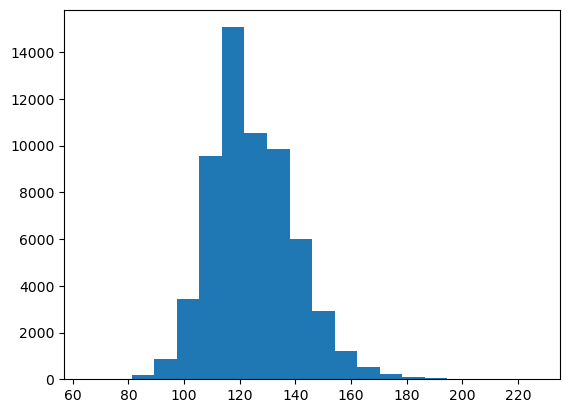

In [8]:
# check the sbp_feedback range in the df when prescribinng ACE, 
df_ace = df[df['ACE']==1]
print('df_ace.shape =', df_ace.shape)
print(min(df_ace['sbp_feedback']))
print(max(df_ace['sbp_feedback']))

# plot the distribution of sbp_feedback
plt.hist(df_ace['sbp_feedback'], bins=20)
plt.show()

df_ace_only.shape = (84684, 67)
66.0
217.0


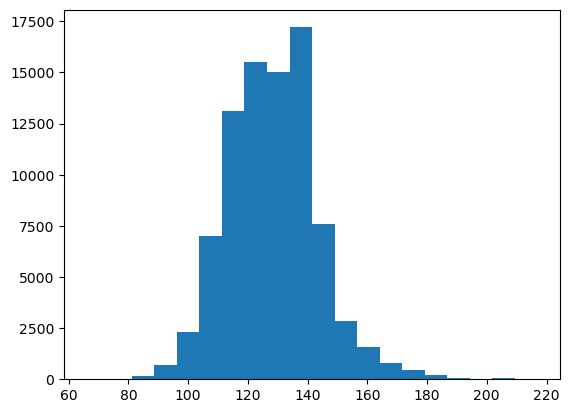

In [18]:
# check the sbp_feedback range in the df when prescribing ACE
df_ace_only = df[df['action_code']=='00000']
print('df_ace_only.shape =', df_ace_only.shape)
print(min(df_ace_only['sbp_feedback']))
print(max(df_ace_only['sbp_feedback']))

# plot the distribution of sbp_feedback
plt.hist(df_ace_only['sbp_feedback'], bins=20)
plt.show()

0 action = 00000
df_action.shape = (84684, 67)
66.0
217.0


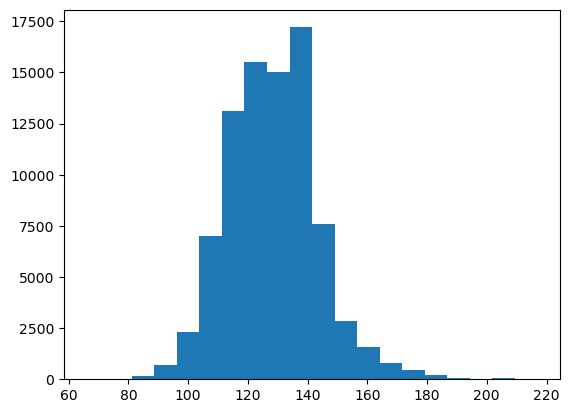

1 action = 00001
df_action.shape = (2822, 67)
78.0
194.0


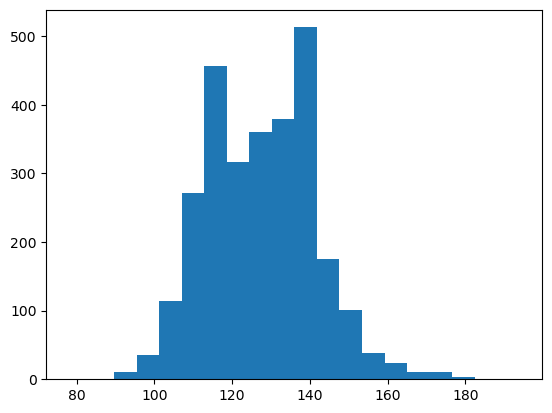

2 action = 00010
df_action.shape = (258, 67)
94.0
181.5


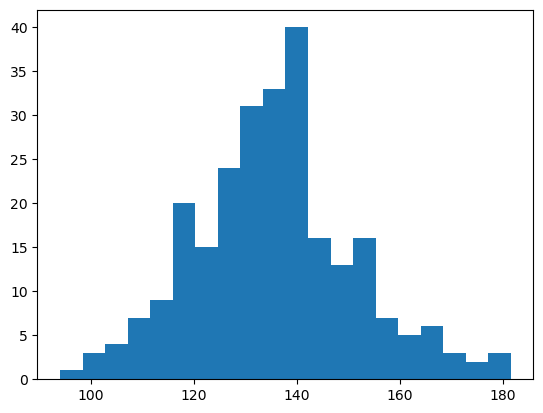

3 action = 00011
df_action.shape = (486, 67)
92.0
192.0


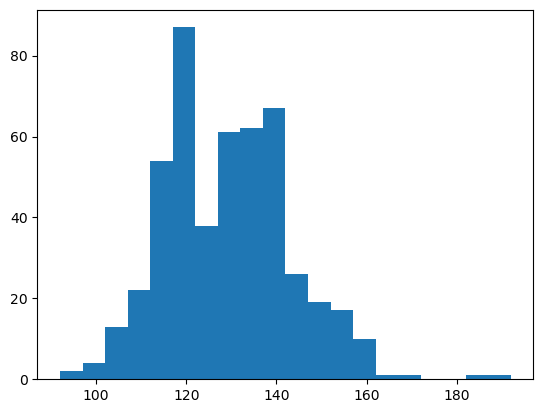

4 action = 00100
df_action.shape = (1051, 67)
80.0
177.0


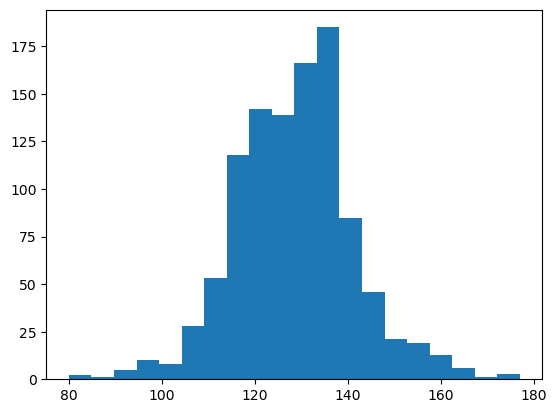

5 action = 00101
df_action.shape = (950, 67)
81.0
205.5


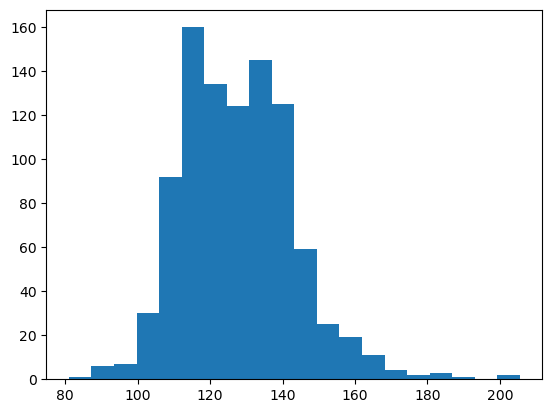

6 action = 00110
df_action.shape = (164, 67)
87.0
186.0


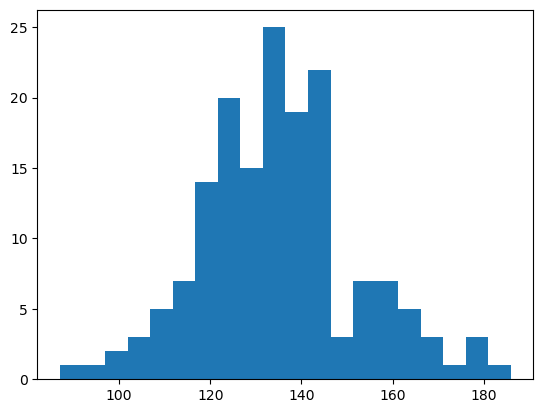

7 action = 00111
df_action.shape = (268, 67)
78.0
181.0


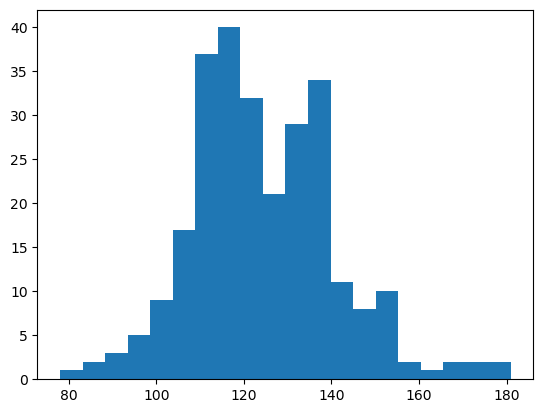

8 action = 01000
df_action.shape = (9470, 67)
75.0
200.0


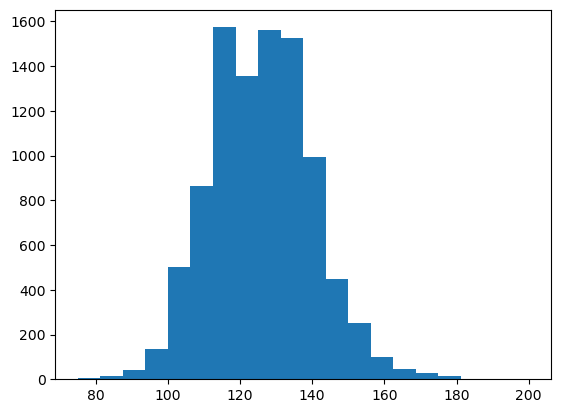

9 action = 01001
df_action.shape = (243, 67)
91.0
176.5


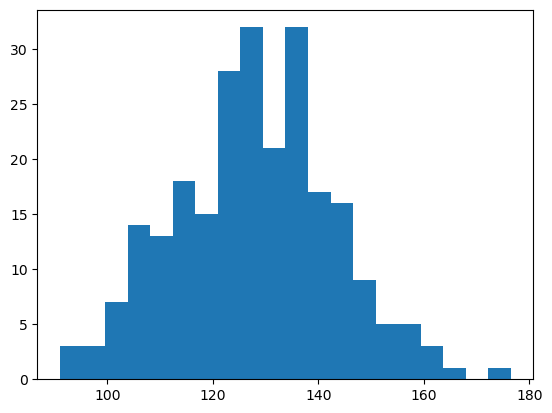

10 action = 01010
df_action.shape = (2155, 67)
84.0
196.0


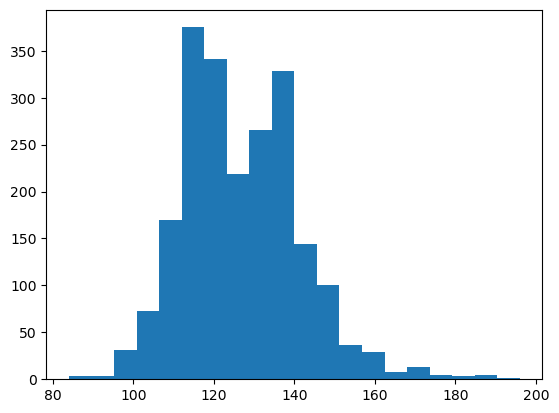

11 action = 01011
df_action.shape = (163, 67)
87.0
177.0


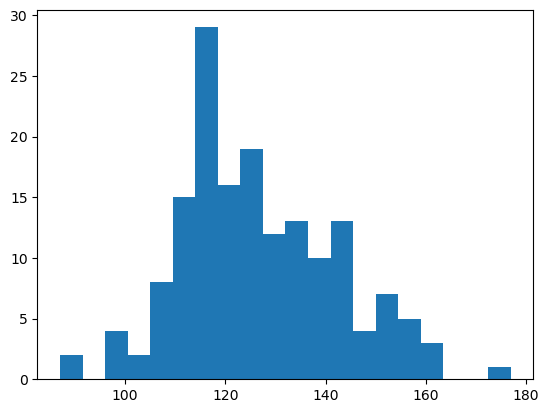

12 action = 01100
df_action.shape = (3017, 67)
81.0
216.0


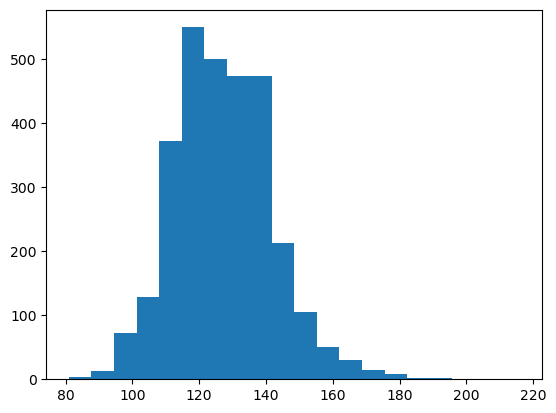

13 action = 01101
df_action.shape = (84, 67)
91.0
172.0


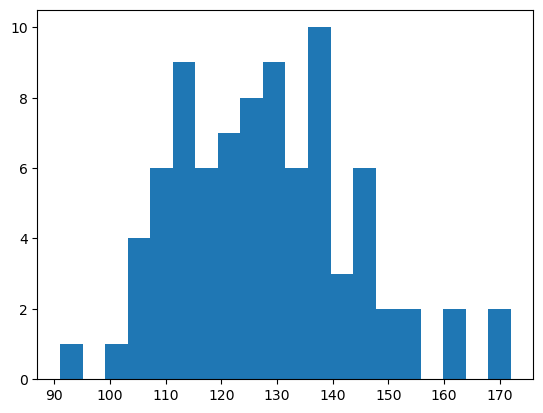

14 action = 01110
df_action.shape = (1162, 67)
76.0
193.0


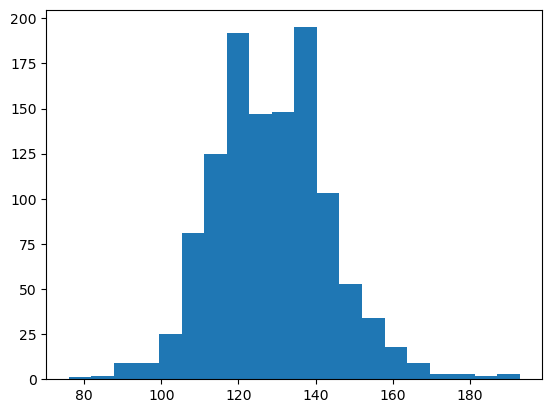

15 action = 01111
df_action.shape = (141, 67)
103.0
175.0


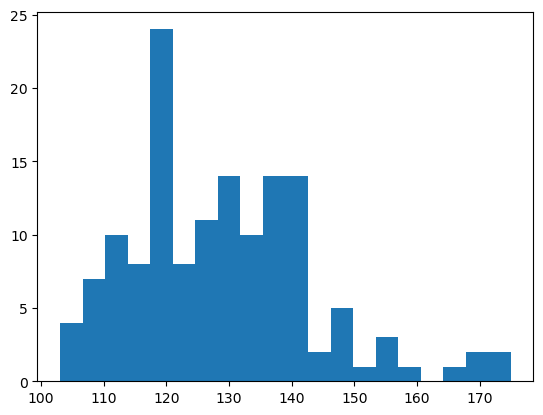

16 action = 10000
df_action.shape = (2023, 67)
81.0
200.0


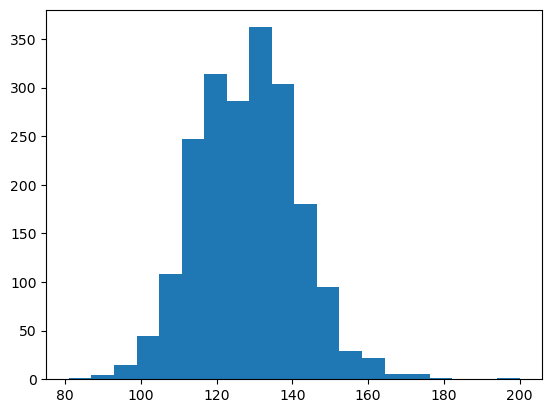

17 action = 10001
df_action.shape = (7717, 67)
76.0
199.5


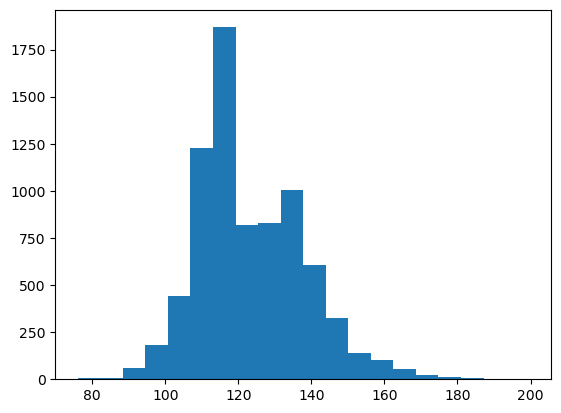

18 action = 10010
df_action.shape = (782, 67)
87.0
194.0


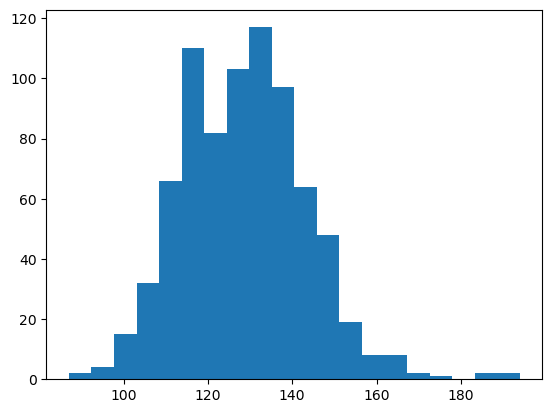

19 action = 10011
df_action.shape = (4046, 67)
76.0
221.0


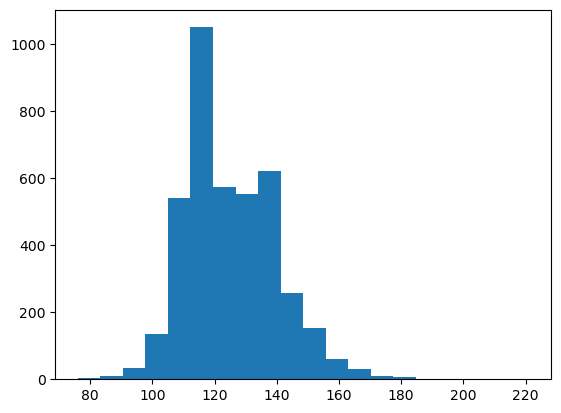

20 action = 10100
df_action.shape = (1851, 67)
81.0
175.0


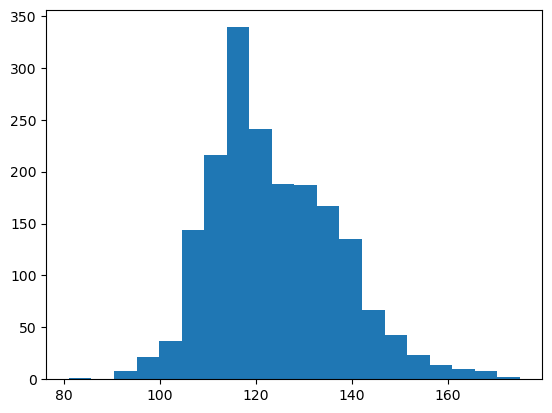

21 action = 10101
df_action.shape = (5307, 67)
74.0
206.0


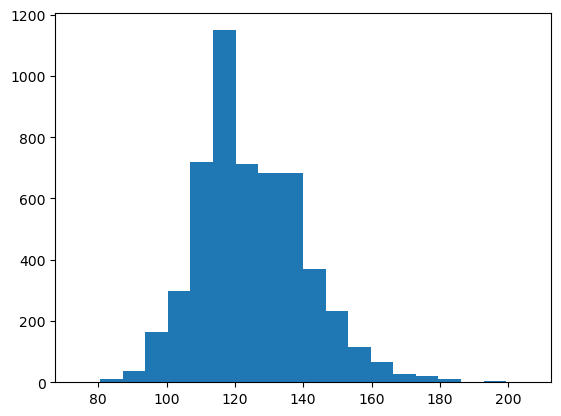

22 action = 10110
df_action.shape = (804, 67)
87.5
205.0


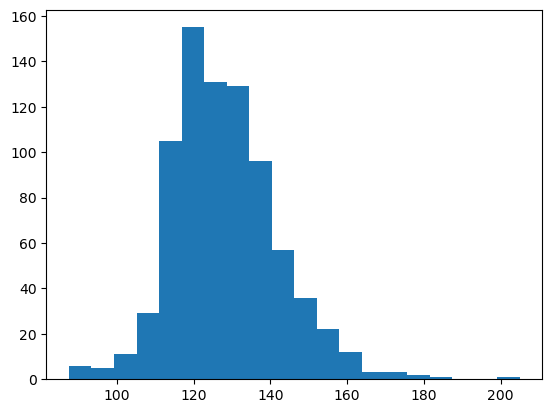

23 action = 10111
df_action.shape = (3103, 67)
66.0
217.0


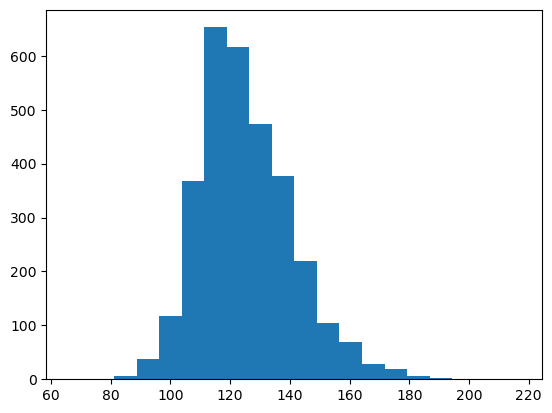

24 action = 11000
df_action.shape = (12684, 67)
72.0
199.0


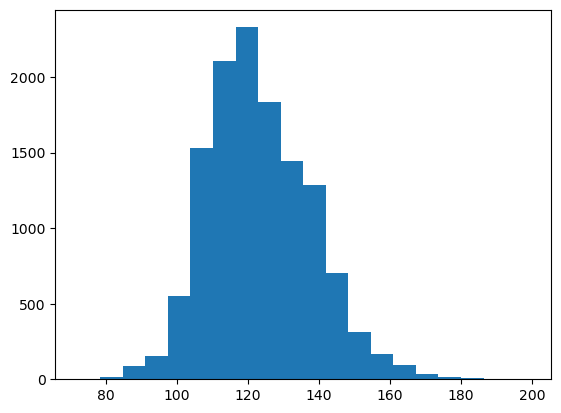

25 action = 11001
df_action.shape = (857, 67)
89.0
217.0


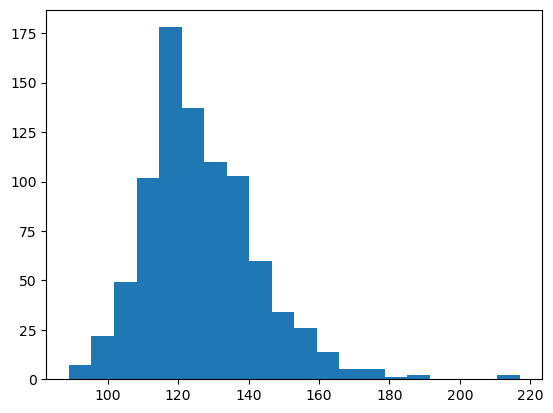

26 action = 11010
df_action.shape = (8415, 67)
74.0
216.0


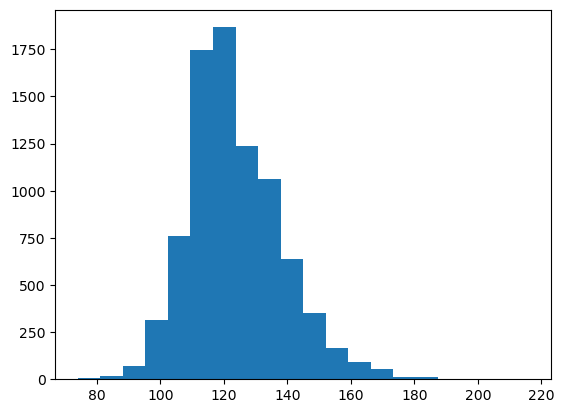

27 action = 11011
df_action.shape = (1934, 67)
66.0
194.0


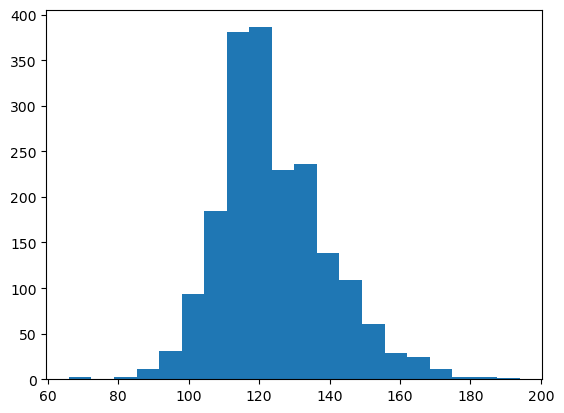

28 action = 11100
df_action.shape = (9733, 67)
65.0
212.0


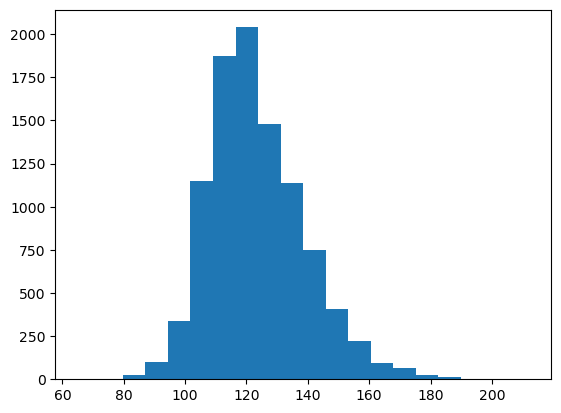

29 action = 11101
df_action.shape = (1043, 67)
81.0
203.0


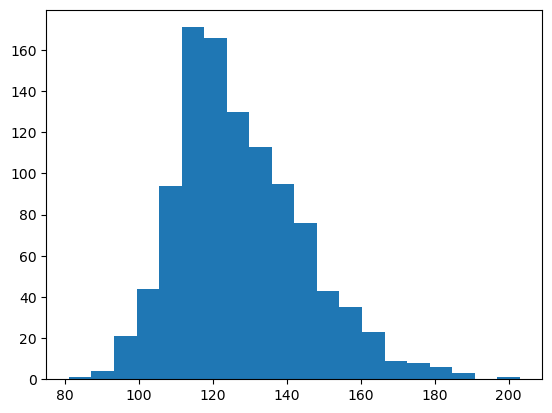

30 action = 11110
df_action.shape = (7313, 67)
67.0
201.0


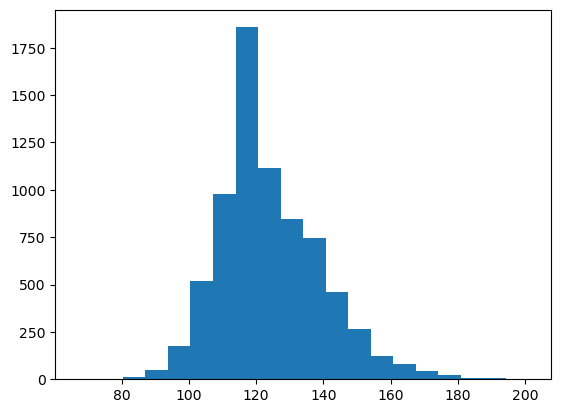

31 action = 11111
df_action.shape = (2176, 67)
81.0
227.0


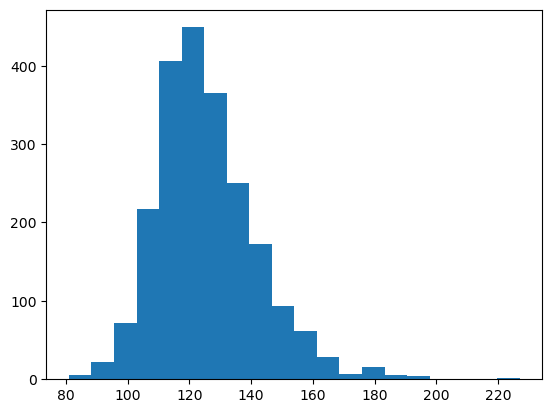

In [20]:
# loop through each possible combination of actions 00000 - 11111 (total 32 combinations), check the corresponding range of sbp_feedback, and plot the distribution
for i in range(32):
    action = str(bin(i))[2:].zfill(5)
    print(i, 'action =', action)
    df_action = df[df['action_code']==action]
    print('df_action.shape =', df_action.shape)
    print(min(df_action['sbp_feedback']))
    print(max(df_action['sbp_feedback']))
    plt.hist(df_action['sbp_feedback'], bins=20)
    plt.show()